In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from class_models import early_stop
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
# setting device and reproducibility
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cuda


## Learning schedule to find the best learning rate using *StepLR* scheduler

In [3]:
# import data 
data_frame = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

In [4]:
# function to calculate the distance of the travel
def haversine_distance(dat_f, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(dat_f[lat1])
    phi2 = np.radians(dat_f[lat2])
    delta_phi = np.radians(dat_f[lat2] - dat_f[lat1])
    delta_lambda = np.radians(dat_f[lon2] - dat_f[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

def preprocessing(df_n, cat_cols):
    """
    Preprocesses the data and adds pandas categorical fields to a dataframe.
    :param df_n: pandas dataframe 
    :param cat_cols: list of categorical fields
    :return: pandas dataframe
    """
    # append a 'dist_km' new feature in the dataframe
    df_n['dist_km'] = haversine_distance(df_n, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
    
    # remove outliers
    dfd = df_n[(df_n['fare_amount'] != 49.57) & (df_n['fare_amount'] != 45.00)].copy()
    
    # convert to pd datetime
    dfd['pickup_datetime'] = pd.to_datetime(dfd['pickup_datetime'])
    
    # Correcting pickup_datetime due to daylight savings time (April)
    dfd['EDTdate'] = dfd['pickup_datetime'] - pd.Timedelta(hours=4)
    
    # create new time fields
    dfd['Hour'] = dfd['EDTdate'].dt.hour
    dfd['AMorPM'] = np.where(dfd['Hour']<12, 'am', 'pm')
    dfd['Weekday'] = dfd['EDTdate'].dt.strftime("%a")
    
    # transform to pandas categorical variables
    for cat in cat_cols:
        dfd[cat] = dfd[cat].astype('category')
    
    dfd = dfd.drop(columns=['pickup_datetime'])
    
    return dfd

def model_tensors(df, cat_cols, cont_cols, y_col):
    """
    Get categorical, continuous and label tensors for the model
    :param df: pd dataframe
    :param cat_cols: list of categorical fields
    :param cont_cols: list of continuous fields
    :param y_col: list with the labels
    :return: cats, conts, y tensors
    """
    
    # group the data in categorical continuous and target label    
    cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
    conts = np.stack([df[col].values for col in cont_cols], axis=1)
    y = df[y_col].values.reshape(-1, 1)

    # Convert to PyTorch tensors
    cats_t = torch.tensor(cats, dtype=torch.int64)
    conts_t = torch.tensor(conts, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    
    return cats_t, conts_t, y_t

def create_embedding_sizes(df, cat_cols):
    """
    Create embedding sizes for PyTorch embedding layers
    :param df: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: emb_sizes list
    """
    # categorical sizes list
    cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

    # embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
    emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
    
    return emb_sizes



In [5]:
df = preprocessing(data_frame, ['Hour', 'AMorPM', 'Weekday'])

cats, conts, y = model_tensors(df, ['Hour', 'AMorPM', 'Weekday'], ['dist_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], ['fare_amount'])

# number of continuous fields of the conts tensor
n_cont = conts.shape[1]

emb_sizes = create_embedding_sizes(df, ['Hour', 'AMorPM', 'Weekday'])

### Model definition

In [6]:
# Define the model
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i

        layer_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### Split Function
Function to split the dataset in 6. `Train data`: cat_train, con_train, y_train; `Test Data`: cat_test, con_test, y_test

In [38]:
def get_train_test(categoricals, continuous, y_train, test_size=0.2):
    # Ensure the input arrays have the same number of rows
    assert categoricals.shape[0] == continuous.shape[0] == y_train.shape[0], "Input arrays must have the same number of rows"

    # Combine the data into a single array for splitting
    combined = np.hstack((categoricals, continuous, y_train))

    # Split and shuffle combined data into train and test sets
    train_data, test_data = train_test_split(combined, test_size=test_size, random_state=42)

    # Determine the number of categorical and continuous columns
    n_cat_cols = categoricals.shape[1]
    n_cont_cols = continuous.shape[1]

    # Separate the train and test data back into categorical, continuous, and target tensors

    # selects all rows and the first n_cat_cols columns (categorical features).
    cat_train = torch.tensor(train_data[:, :n_cat_cols], dtype=torch.int64).to(device)

    # selects all rows and the columns from n_cat_cols to n_cat_cols + n_cont_cols (continuous features).
    con_train = torch.tensor(train_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)

    # selects all rows and the last column (target labels).
    y_train = torch.tensor(train_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    cat_test = torch.tensor(test_data[:, :n_cat_cols], dtype=torch.int64).to(device)
    con_test = torch.tensor(test_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)
    y_test = torch.tensor(test_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    return cat_train, con_train, y_train, cat_test, con_test, y_test

cat_train, con_train, y_train, cat_test, con_test, y_test = get_train_test(cats, conts, y)

## General Configuration for all trainings
### Defining a training function for learning schedules 

In [39]:
# Training function
def train(epochs, train_schedule, start_lr, early_s_patience, print_rate):
    """
    :param epochs: int, number of training epochs
    :param train_schedule: list of lists, [[mode, scheduler_step_size, reduction_factor_gamma]]
    :param start_lr: float, starting learning rate
    :param early_s_patience: int, early stopping patience
    :param print_rate: int, printing rate
    :return: Pandas.DataFrame, the results of the training
    """
    results = []
    start_time = time.time()
    for mode, step_size, gamma in train_schedule:
        print(f"Training mode: {mode}")
        
        # model instance (output_size = 1 for regression task)
        model = TabularModel(emb_sizes, conts.shape[1], 1, [400, 300, 200, 100], p=0.4).to(device)
        
        # criteria
        criterion = nn.SmoothL1Loss()

        # TensorDatasets
        train_dataset = TensorDataset(cat_train, con_train, y_train)
        test_dataset = TensorDataset(cat_test, con_test, y_test)

        batch_size = 128

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # restart optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
        
        if mode == "LR Scheduler":
            # restart learning rate scheduler
            scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
        
        # reset early stop
        early_stopping = early_stop.EarlyStopping(patience=early_s_patience)
        for epoch in range(epochs):
            
            train_losses = []
            val_losses = []
            
            model.train()
            epoch_losses = []
            for cat_batch, con_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(cat_batch, con_batch).flatten()
                loss = torch.sqrt(criterion(y_pred, y_batch.flatten()))  # Use y_batch.flatten() here
                epoch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
        
            train_losses.append(np.mean(epoch_losses))
        
            # Validation
            model.eval()
            with torch.no_grad():
                epoch_val_loss = []
                for cat_batch, con_batch, y_batch in test_loader:
                    y_val = model(cat_batch, con_batch).flatten()
                    val_loss = torch.sqrt(criterion(y_val, y_batch.flatten()))  # Use y_batch.flatten() here
                    epoch_val_loss.append(val_loss.item())
        
                val_losses.append(np.mean(epoch_val_loss))
        
            if (epoch % print_rate == 0 or epoch == epochs - 1) and mode == "LR Scheduler":
                print(f'Epoch {epoch + 1}/{epochs}, T. Loss: {train_losses[-1]:.4f}, V. Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}, Gamma: {gamma}, S. Size: {step_size}, L.R. {optimizer.param_groups[0]['lr']:.6f}')
            elif epoch % print_rate == 0 or epoch == epochs - 1: 
                print(f'Epoch {epoch + 1}/{epochs}, T. Loss: {train_losses[-1]:.4f}, V. Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}, L.R. {optimizer.param_groups[0]['lr']:.6f}')
            
            if mode == "LR Scheduler":
                results.append({
                    "Mode": mode,
                    "Gamma": gamma,
                    "Step": step_size,
                    "Epoch": epoch + 1,
                    "Learning Rate": optimizer.param_groups[0]['lr'],
                    "Train Loss": train_losses[-1],
                    "Validation Loss": val_losses[-1],
                })
            else:
                results.append({
                    "Mode": mode,
                    "Epoch": epoch + 1,
                    "Learning Rate": optimizer.param_groups[0]['lr'],
                    "Train Loss": train_losses[-1],
                    "Validation Loss": val_losses[-1],
                })
            
            if mode == "LR Scheduler":
                scheduler.step()
            
            # Check early stopping
            if early_stopping(model, val_losses[-1]):  # Pass the latest validation loss to early stopping
                print(early_stopping.status)
                break
        
        print(f'Training completed in {time.time() - start_time:.2f} seconds')

    return pd.DataFrame(results)

### Train Schedule 1: 

In [40]:
training_epochs = 500
train_lr_schedule = [
    ["LR Scheduler", 15, 0.95],
    ["LR Scheduler", 10, 0.95],
    ["LR Scheduler", 5, 0.95]
]
starting_lr = 0.01
early_stop_patience = 100
printing_rate = 50

results_lr_09_500 = train(training_epochs, train_lr_schedule, starting_lr, early_stop_patience, printing_rate)

Training mode: LR Scheduler
Epoch 1/500, T. Loss: 1.2855, V. Loss: 1.0384, Early S: , Gamma: 0.95, S. Size: 15, L.R. 0.010000
Epoch 51/500, T. Loss: 1.0514, V. Loss: 0.9566, Early S: NO improvement in the last 1 epochs, Gamma: 0.95, S. Size: 15, L.R. 0.008574
Epoch 101/500, T. Loss: 1.0366, V. Loss: 0.9263, Early S: NO improvement in the last 7 epochs, Gamma: 0.95, S. Size: 15, L.R. 0.007351
Epoch 151/500, T. Loss: 1.0325, V. Loss: 0.9218, Early S: NO improvement in the last 18 epochs, Gamma: 0.95, S. Size: 15, L.R. 0.005987
Epoch 201/500, T. Loss: 1.0258, V. Loss: 0.9248, Early S: NO improvement in the last 68 epochs, Gamma: 0.95, S. Size: 15, L.R. 0.005133
Epoch 251/500, T. Loss: 1.0254, V. Loss: 0.9214, Early S: NO improvement in the last 21 epochs, Gamma: 0.95, S. Size: 15, L.R. 0.004401
Epoch 301/500, T. Loss: 1.0177, V. Loss: 0.9223, Early S: NO improvement in the last 3 epochs, Gamma: 0.95, S. Size: 15, L.R. 0.003585
Epoch 351/500, T. Loss: 1.0177, V. Loss: 0.9279, Early S: NO i

In [32]:
from scipy import stats

summary_stats = results_lr_09_500.groupby(['Mode', 'Step']).agg({
    'Train Loss': ['mean', 'std', 'min', 'max'],
    'Validation Loss': ['mean', 'std', 'min', 'max'],
    'Epoch': ['min']
}).reset_index()

print(summary_stats)

           Mode Step Train Loss                               Validation Loss  \
                           mean       std       min       max            mean   
0  LR Scheduler    5   1.028559  0.023523  1.008132  1.281686        0.938712   
1  LR Scheduler   10   1.029129  0.022758  1.006976  1.287808        0.937255   

                                Epoch  
        std       min       max   min  
0  0.019214  0.914315  1.070468     1  
1  0.018205  0.908924  1.079094     1  


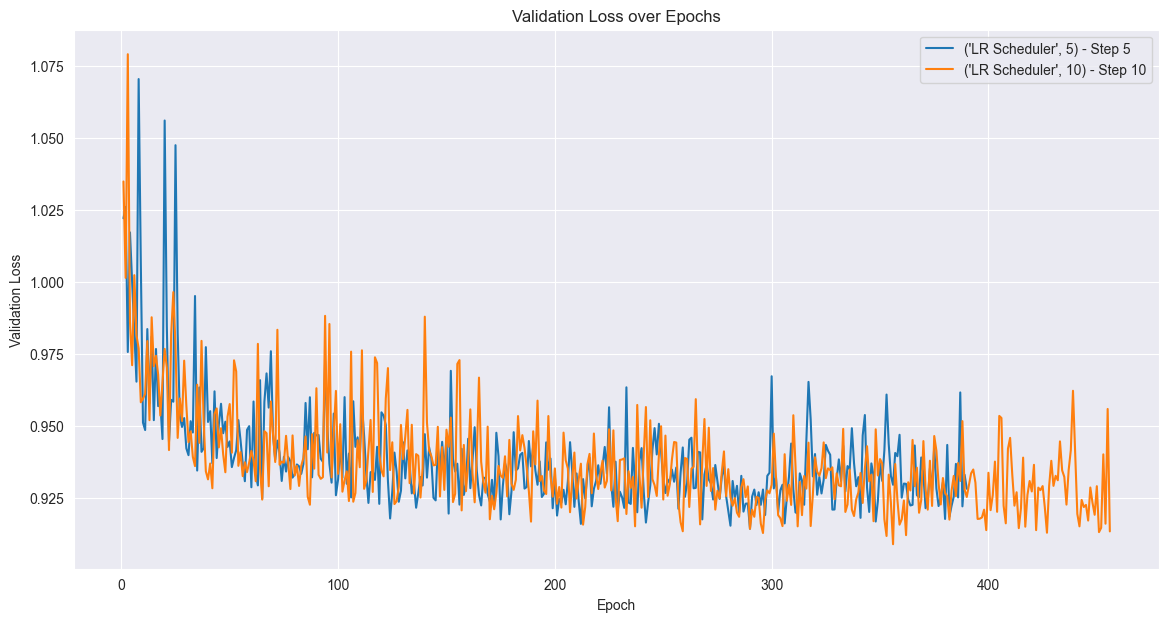

In [33]:
# Plotting the Loss Curves
plt.figure(figsize=(14, 7))
for mode, group in results_lr_09_500.groupby(['Mode', 'Step']):
    plt.plot(group['Epoch'], group['Validation Loss'], label=f'{mode} - Step {group["Step"].iloc[0]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

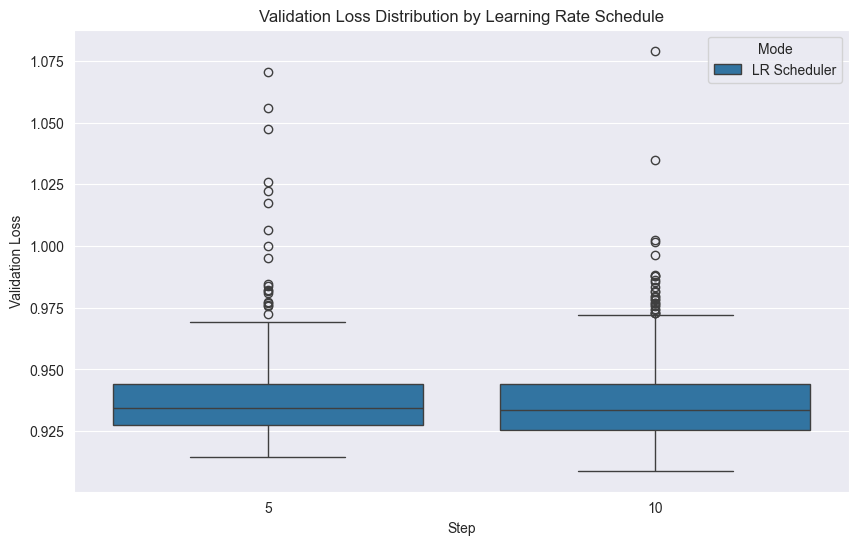

In [34]:
# Boxplots for Validation Loss
plt.figure(figsize=(10, 6))
sns.boxplot(x='Step', y='Validation Loss', hue='Mode', data=results_lr_09_500)
plt.title('Validation Loss Distribution by Learning Rate Schedule')
plt.show()

In [30]:
# evaluate the entire set
with torch.no_grad():
    y_val = model(cat_test, con_test).flatten()
    loss = torch.sqrt(criterion(y_val, y_test.flatten()))
print(f'Root Mean Squared Error of the entire set: {loss.item():.4f}')
    

Root Mean Squared Error of the entire set: 0.9181


In [28]:
# prediction of 50 first values
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   5.2857   5.7000   0.4143
 2.   7.5370   6.5000   1.0370
 3.  13.1497  12.1000   1.0497
 4.   8.7964   8.5000   0.2964
 5.   6.7418   6.1000   0.6418
 6.   7.8927   7.7000   0.1927
 7.   5.9543   6.5000   0.5457
 8.  38.6604   9.7000  28.9604
 9.   8.0283   8.1000   0.0717
10.   5.4168   5.3000   0.1168
11.   5.8631   6.5000   0.6369
12.   8.9394  10.9000   1.9606
13.   9.8832   8.9000   0.9832
14.  17.4026  15.3000   2.1026
15.   9.3754   7.7000   1.6754
16.   4.8568   5.3000   0.4432
17.   8.0337   8.5000   0.4663
18.   5.9778   4.9000   1.0778
19.   7.8965   9.7000   1.8035
20.  10.9475  12.1000   1.1525
21.   4.2573   4.1000   0.1573
22.   5.3701   4.5000   0.8701
23.   4.4664   4.9000   0.4336
24.  24.9076  19.3000   5.6076
25.  21.5893   2.5000  19.0893
26.   5.7534   6.1000   0.3466
27.   6.9324   8.1000   1.1676
28.   4.4966   3.3000   1.1966
29.   6.3360   6.1000   0.2360
30.  14.8559  15.3000   0.4441
31.  24.6100  24.6700   0.0600
32.  12.

In [12]:
results_lr_08 = pd.read_csv('export/results_lr_08.csv')
results_lr_08.head(10)

,Mode,Gamma,Step,Epoch,Learning Rate,Train Loss,Validation Loss
0,LR Scheduler,0.8,25,1,0.01,1.285750,1.050479
1,LR Scheduler,0.8,25,2,0.01,1.156933,1.017651
2,LR Scheduler,0.8,25,3,0.01,1.127759,0.978055
3,LR Scheduler,0.8,25,4,0.01,1.118546,0.988594
4,LR Scheduler,0.8,25,5,0.01,1.103067,0.987877
5,LR Scheduler,0.8,25,6,0.01,1.099972,0.970400
6,LR Scheduler,0.8,25,7,0.01,1.095743,0.960639
7,LR Scheduler,0.8,25,8,0.01,1.090149,1.038049
8,LR Scheduler,0.8,25,9,0.01,1.083485,0.952243
9,LR Scheduler,0.8,25,10,0.01,1.078036,0.952508


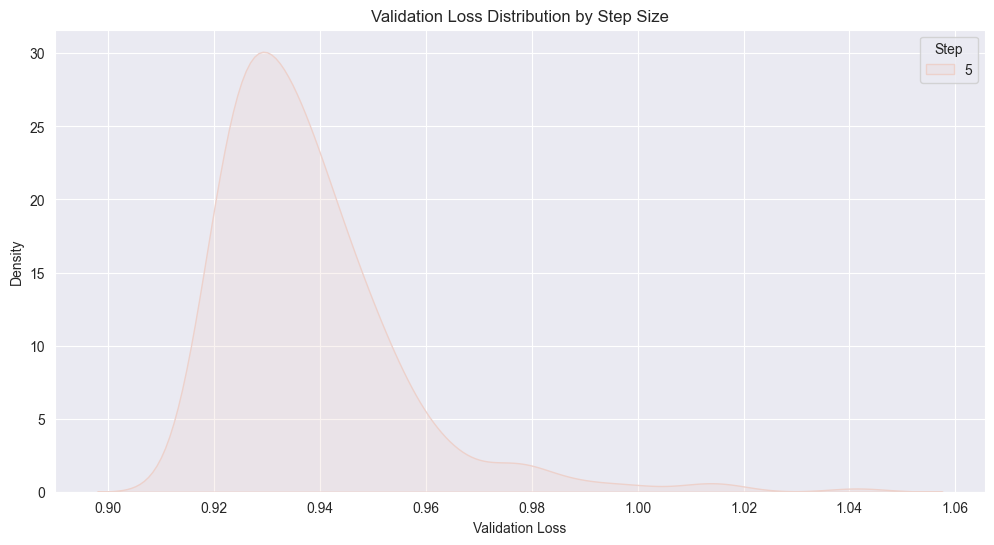

In [29]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=results_lr_09_500, x='Validation Loss', hue='Step', fill=True)
plt.title('Validation Loss Distribution by Step Size')
plt.xlabel('Validation Loss')
plt.ylabel('Density')
plt.show()

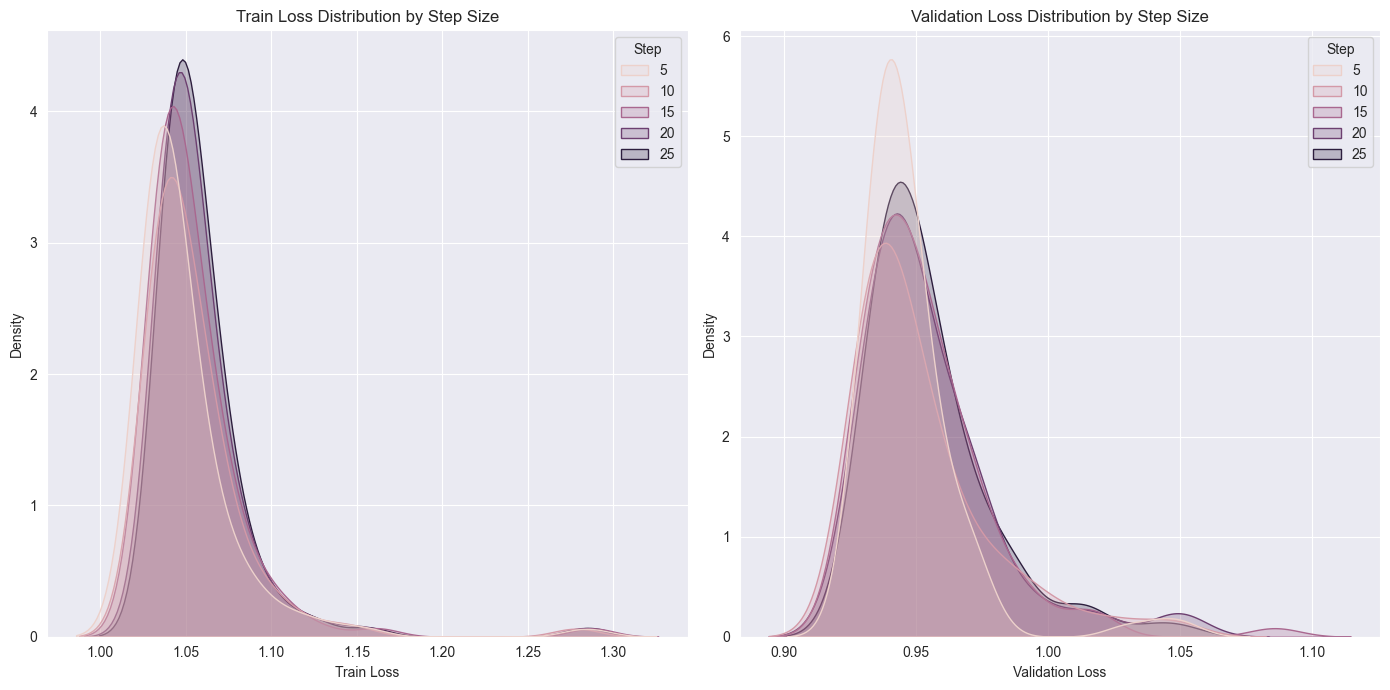

In [14]:
plt.figure(figsize=(14, 7))

# Train Loss
plt.subplot(1, 2, 1)
sns.kdeplot(data=results_lr_08, x='Train Loss', hue='Step', fill=True)
plt.title('Train Loss Distribution by Step Size')
plt.xlabel('Train Loss')
plt.ylabel('Density')

# Validation Loss
plt.subplot(1, 2, 2)
sns.kdeplot(data=results_lr_08, x='Validation Loss', hue='Step', fill=True)
plt.title('Validation Loss Distribution by Step Size')
plt.xlabel('Validation Loss')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

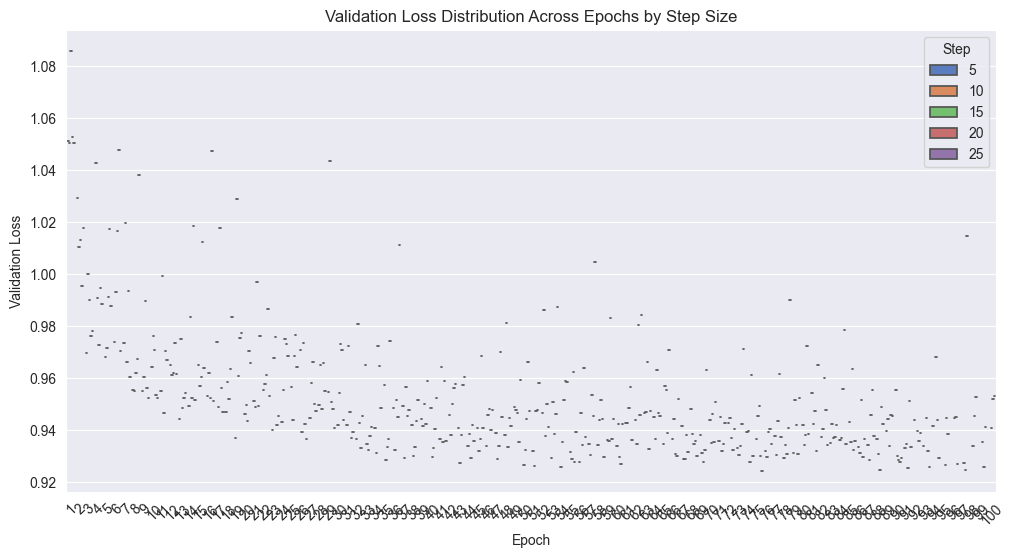

In [15]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Epoch', y='Validation Loss', hue='Step', data=results_lr_08, split=True, inner="quart", palette="muted")
plt.title('Validation Loss Distribution Across Epochs by Step Size')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(rotation=45)
plt.show()

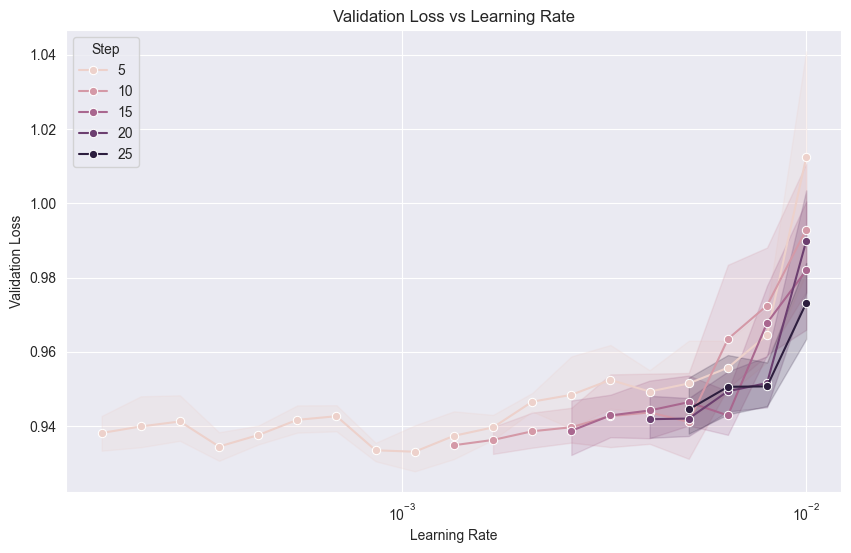

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_lr_08, x='Learning Rate', y='Validation Loss', hue='Step', marker="o")
plt.title('Validation Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.xscale('log')  # Learning rate is often better visualized on a log scale
plt.show()

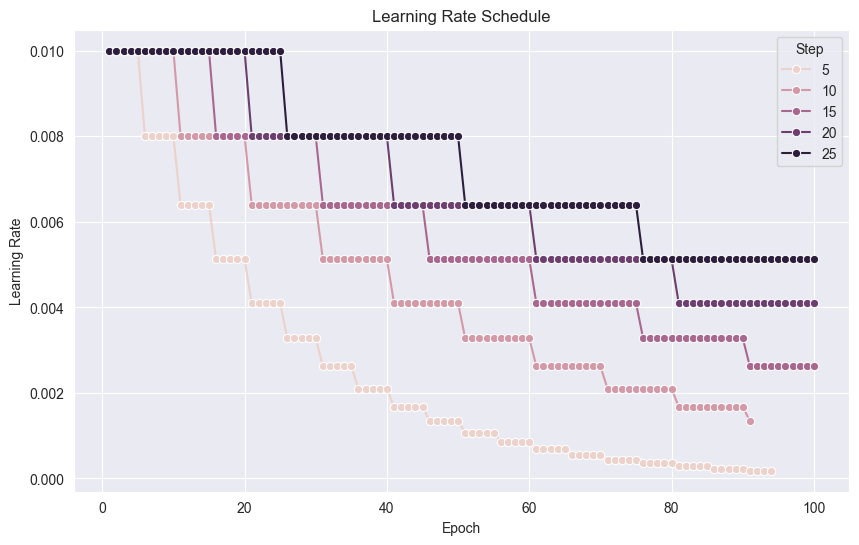

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_lr_08, x='Epoch', y='Learning Rate', hue='Step', marker="o")
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()